Gerekli kütüphaneler eklendi.

In [ ]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from google.colab import drive

!pip install transformers
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

     |████████████████████████████████| 3.4 MB 12.4 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 895 kB 48.7 MB/s 
     |████████████████████████████████| 596 kB 48.7 MB/s 
     |████████████████████████████████| 3.3 MB 45.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Gpu kontrolü

In [ ]:
# check GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla K80


Dataset path kaydediliyor,google drive ile bağlantı kuruluyor

In [ ]:
# set environment as googledrive to folder "resource"
data_path =  "/resource/"

try:
    drive.mount('/content/drive')
    data_path = "/content/drive/My Drive/resource/"

except:
    print("You are not working in Colab at the moment :(")

Mounted at /content/drive


Dataset okunuyor

In [ ]:
df = pd.read_csv(data_path + 'coraDataset.csv')

Dataset bilgileri yazdırılıyor

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2708 entries, 0 to 2707
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2708 non-null   object
 1   text      2708 non-null   object
dtypes: object(2)
memory usage: 42.4+ KB


Datasetten 10 örnek gösteriliyor

In [ ]:
df.sample(10)

,category,text
1579,Neural_Networks,support vector machin approach decis tree key ...
2539,Theory,mdl mml similar differ introduct minimum encod...
1369,Theory,bayesian method adapt model forward probabl us...
2198,Neural_Networks,temper backpropag network weight creat equal a...
617,Probabilistic_Methods,improv model spatial correl binari respons pap...
137,Neural_Networks,stabil chao inerti two neuron system statist m...
2681,Theory,develop probabilist model neural network ensem...
2514,Neural_Networks,analyt framework local feedforward network int...
26,Genetic_Algorithms,evolutionari cost learn trait acquir member ev...
298,Genetic_Algorithms,reformul design optim strategi automat design ...


Datasetteki etiket sayıları gösteriliyor

In [ ]:
df.groupby('category').size()

category
Case_Based                298
Genetic_Algorithms        418
Neural_Networks           818
Probabilistic_Methods     426
Reinforcement_Learning    217
Rule_Learning             180
Theory                    351
dtype: int64

Labelleri encode ediyoruz

In [ ]:
df['encoded_categories'] = LabelEncoder().fit_transform(df['category'])

Tokenizer indirildi
Bert modeli indirildi

In [ ]:
from transformers import AutoTokenizer, AutoModel
  
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

model = AutoModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentences a text leri atıyoruz

In [ ]:
sentences = df.text.values

Max kelime sayısını 200 yapıyoruz GPU hatası almamak için

In [ ]:
max_len = 200

%80 ve %20 oranıyla  training ve test olarak veriyi ikiye bölcdüm

In [ ]:
training = df.groupby('category').apply(lambda x : x.sample(frac = 0.8))
test = pd.concat([df,training]).drop_duplicates(keep=False)

In [ ]:
print("Training: ", len(training))
print("Test: ", len(test))

Training:  2166
Test:  538


In [ ]:
training_texts = training.text.values
training_labels = training.encoded_categories.values

Cümleler tokenizer ile bölünüyor
Max uzunluğa göre ayarlamalar yapılıyor
Attention mask yapılıyor
Tensor objesi oluşturuluyor
Kelimeler id lerle ifade ediliyor

In [ ]:
input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True,
                        max_length = max_len,      
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  correct length bias convers case score infer convers case base reason ccbr approach embed cbr content navig line product suscept bia case score algorithm particular shorter case tend given higher score assum factor held constant report summar investig mediat bia introduc approach elimin bia evalu affect retriev perform six case librari also suggest explan result note limit studi rel frequenc select solut solv given problem retriev effici defin invers function number question answer solut retriev bias case score develop ccbr tool name nacoda navi convers decis aid environ breslow aha combin bias shorter longer case sometim effect use one isol use leav one aha breslow strategi evalu case retriev perform strategi similar well known leav one cross valid except case ever remov case librari might uniqu respect solut date approach test simultan increas retriev precis retriev effici case librari revis describ aha breslow initi analysi result show clear statist trend explain expect n

Tensor objesi dataloadera verilip model e uygun hale getiriliyorBatch size aynı anda kaç verinin işleneceğini belirler

In [ ]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

In [ ]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

In [ ]:
number_of_categories = len(df['encoded_categories'].unique())

Fine tuning işlemi yapılıyor

In [ ]:
#model = AutoModel.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = number_of_categories, 
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Train epoch sayısı verilip eğitim yapılıyor

In [ ]:
epochs = 15

optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 1903

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = output['loss']
        logits = output['logits']
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 15 ========
Batch    10  of     68.    Elapsed: 0:00:22.
Batch    20  of     68.    Elapsed: 0:00:43.
Batch    30  of     68.    Elapsed: 0:01:05.
Batch    40  of     68.    Elapsed: 0:01:26.
Batch    50  of     68.    Elapsed: 0:01:48.
Batch    60  of     68.    Elapsed: 0:02:09.
Average training loss: 1.05
Training epoch took: 0:02:26
======== Epoch 2 / 15 ========
Batch    10  of     68.    Elapsed: 0:00:21.
Batch    20  of     68.    Elapsed: 0:00:43.
Batch    30  of     68.    Elapsed: 0:01:04.
Batch    40  of     68.    Elapsed: 0:01:26.
Batch    50  of     68.    Elapsed: 0:01:47.
Batch    60  of     68.    Elapsed: 0:02:09.
Average training loss: 0.77
Training epoch took: 0:02:25
======== Epoch 3 / 15 ========
Batch    10  of     68.    Elapsed: 0:00:21.
Batch    20  of     68.    Elapsed: 0:00:43.
Batch    30  of     68.    Elapsed: 0:01:04.
Batch    40  of     68.    Elapsed: 0:01:26.
Batch    50  of     68.    Elapsed: 0:01:47.
Batch    60  of     68.    E

Sonuçlar İnceleniyor

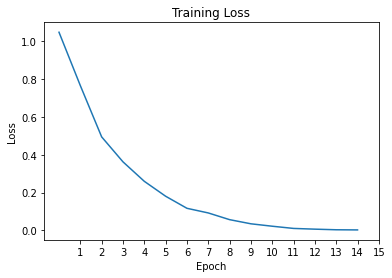

In [ ]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
plt.show()

Test içinde traning işlemi yapılıyor

In [ ]:
test_texts = test.text.values
test_labels = test.encoded_categories.values

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

Prediction started on test data
Prediction completed


In [ ]:
prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

In [ ]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

In [ ]:
print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

F-Score:  0.8060891766192311
Recall:  0.8223676851425334
Precision:  0.7978703975879714


In [ ]:
report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))

In [ ]:
report = report.rename(columns={'0':'Case_Based',
                          '1':'Genetic_Algorithms',
                          '2':'Neural_Networks',
                          '3':'Probabilistic_Methods',
                          '4':'Reinforcement_Learning',
                          '5':'Rule_Learning',
                          '6':'Theory'})

        

In [ ]:
report

,Case_Based,Genetic_Algorithms,Neural_Networks,Probabilistic_Methods,Reinforcement_Learning,Rule_Learning,Theory,accuracy,macro avg,weighted avg
precision,0.851852,0.897436,0.896104,0.822785,0.706897,0.707317,0.702703,0.819703,0.797870,0.827220
recall,0.766667,0.853659,0.846626,0.764706,0.953488,0.828571,0.742857,0.819703,0.822368,0.819703
f1-score,0.807018,0.875000,0.870662,0.792683,0.811881,0.763158,0.722222,0.819703,0.806089,0.820900
support,60.000000,82.000000,163.000000,85.000000,43.000000,35.000000,70.000000,0.819703,538.000000,538.000000
